In [1]:
import pandas as pd
import numpy as np
from dotenv import dotenv_values, find_dotenv
import matplotlib.pyplot as plt
import os
config = dotenv_values(find_dotenv())
path_cleandata = os.path.abspath(config["CLEANDATA"]) + '\\'
path_figures = os.path.abspath(config["FIGURES"]) + '\\'

In [9]:
# import my merged data
data = pd.read_pickle(path_cleandata + 'BEA6_naics6_merged.pkl')

In [10]:
# filter for the year 2017 
data2017 = data[data['date'].dt.year == 2017]

In [11]:
# personal consumption expenditures
data2017 = data2017[data2017['product_O'].str.contains('Personal consumption expenditures')][['product_I', 'date', 'IO_value', 'expenditures_I']]

In [12]:
# sum by product for that year
# first groupby: take sum of IO_value and mean of expenditures_I by date and product
byproduct = data2017.groupby(['product_I']).agg({
    'IO_value': 'mean',
    'expenditures_I': 'mean'}, min_count=1).reset_index()


In [13]:
byproduct.set_index('product_I')[['IO_value', 'expenditures_I']].sum(axis=0)

IO_value          10278053.00
expenditures_I    13488933.75
dtype: float64

## taking a look at how well the merge worked

In [14]:
# create distance variable
byproduct['distance'] = np.abs(byproduct['IO_value'] - byproduct['expenditures_I'])

# kinda "outliers" that have a very different value
outlier_threshold = 75000

# Filter only the points that are outliers
outliers = byproduct[byproduct['distance'] > outlier_threshold]

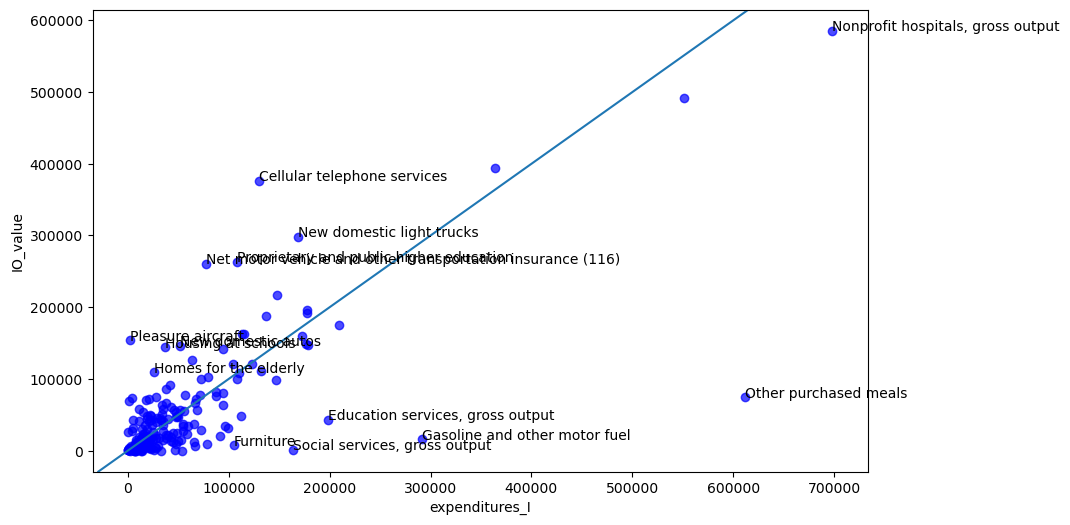

In [15]:
# do the scatter plot with expenditures on the x axis

plt.figure(figsize=(10, 6))
plt.scatter(byproduct['expenditures_I'], byproduct['IO_value'], c='blue', alpha=0.7)

plt.xlabel('expenditures_I')
plt.ylabel('IO_value')

ax = plt.gca()
ax.axline((0, 0), slope=1)

for idx, row in byproduct.iterrows():
    if byproduct['product_I'][idx] in list(set(outliers['product_I'])):
        plt.annotate(byproduct['product_I'][idx], (byproduct['expenditures_I'][idx], byproduct['IO_value'][idx]))

plt.savefig(path_figures + 'merge_check\\expenditures.pdf')

In [16]:
# this is the list of "outlier" products: issues mostly come from housing and healthcare type stuff
# noting the 2017 expenditures for tenant-occupied stationary houses is 0: having trouble getting min_count to work (actually all NaNs)
# within the merge, foreign travel in the United States gets matched with the rest-of-world adjustment in the IO table, which i should probably get rid of
outliers

,product_I,IO_value,expenditures_I,distance
17,Cellular telephone services,376594.734893,130412.25,246182.484893
37,"Education services, gross output",43016.493796,198067.25,155050.756204
59,Furniture,7578.726690,104784.25,97205.523310
62,Gasoline and other motor fuel,15506.553708,291553.50,276046.946292
67,Homes for the elderly,109178.399260,25700.75,83477.649260
73,Housing at schools,144351.331632,36319.00,108032.331632
109,Net motor vehicle and other transportation ins...,260868.348077,77603.00,183265.348077
112,New domestic autos,146544.973382,51958.25,94586.723382
113,New domestic light trucks,298255.059932,168548.25,129706.809932
119,"Nonprofit hospitals, gross output",585809.128035,698362.00,112552.871965


In [17]:
# go into concordance, which shows some of the issues

concordance = pd.read_pickle(path_cleandata + 'concordance//concordance6_naics6_addproportions.pkl')
outlierproducts = list(outliers['product_I'])

outliermerges = concordance[concordance['product'].isin(outlierproducts)]
outliermerges

,product,NAICS_desc,IO_proportions
47,Cellular telephone services,Wired telecommunications carriers,1.000000
48,Cellular telephone services,Wireless telecommunications carriers (except s...,0.591606
49,Cellular telephone services,Broadcast and wireless communications equipment,0.549908
77,New domestic light trucks,Light truck and utility vehicle manufacturing,0.678548
129,Other purchased meals,All other food and drinking places,0.685839
130,Other purchased meals,Food and beverage stores,0.654742
166,Proprietary and public higher education,"Junior colleges, colleges, universities, and p...",1.000000
167,Proprietary and public higher education,Other educational services,0.326914
168,Proprietary and public higher education,Educational and vocational structures,0.635854
176,Pleasure aircraft,Aircraft manufacturing,1.000000


c:\Users\EmilyFu\.conda\envs\myenv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\EmilyFu\.conda\envs\myenv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


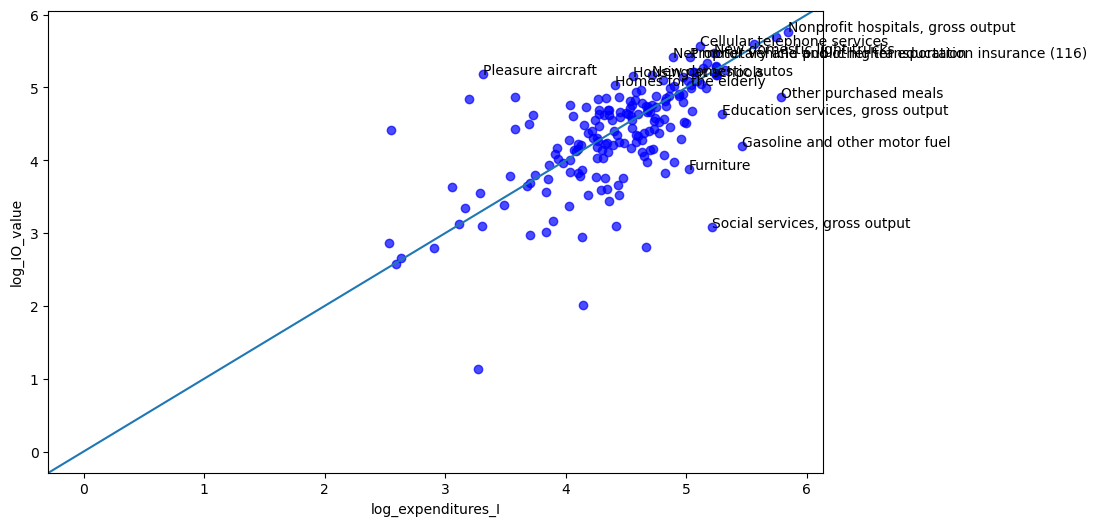

In [18]:
# get logs of everything and do an equivalent scatter plot with those

# do the scatter plot with expenditures on the x axis 
# do a base 10 log
plt.figure(figsize=(10, 6))
plt.scatter(np.log10(byproduct['expenditures_I']), np.log10(byproduct['IO_value']), c='blue', alpha=0.7)

plt.xlabel('log_expenditures_I')
plt.ylabel('log_IO_value')

ax = plt.gca()
ax.axline((0, 0), slope=1)


for idx, row in byproduct.iterrows():
    if byproduct['product_I'][idx] in list(set(outliers['product_I'])):
        plt.annotate(byproduct['product_I'][idx], (np.log10(byproduct['expenditures_I'])[idx], np.log10(byproduct['IO_value'])[idx]))

plt.savefig(path_figures + 'merge_check\\log_expenditures.pdf')
